# Exploding Gradients Problem

Exploding gradients means that the magnitude of the gradients becomes extremely large resulting in extreme weights and NaN values.

# Exploding gradients in a MLP with linear activation functions

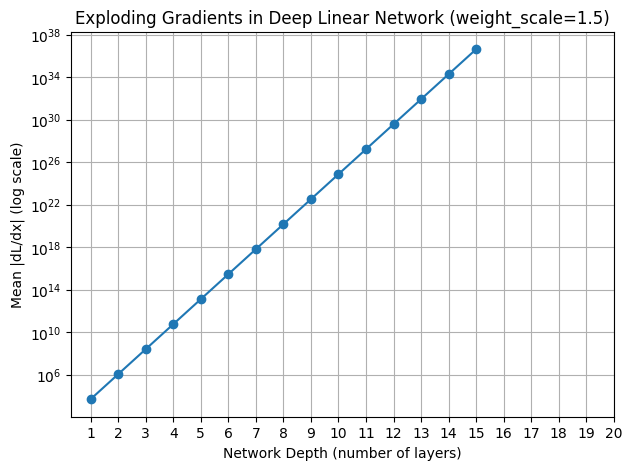

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

# Simple deep linear network (no activation)
class DeepLinear(nn.Module):
    def __init__(self, depth=10, width=10, weight_scale=1.5):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(width, width, bias=False) for _ in range(depth)
        ])
        # Initialize weights to a fixed value > 1 (causes explosion)
        for layer in self.layers:
            nn.init.constant_(layer.weight, weight_scale)
        self.output = nn.Linear(width, 1, bias=False)
        nn.init.constant_(self.output.weight, weight_scale)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output(x)

# Setup
depths = range(1, 21)
width = 10
weight_scale = 1.5
grad_means = []

# Compute gradient magnitudes for increasing depth
for D in depths:
    model = DeepLinear(depth=D, width=width, weight_scale=weight_scale)
    x = torch.ones((1, width), requires_grad=True)
    y_pred = model(x)
    loss = 0.5 * (y_pred ** 2).sum()
    loss.backward()
    grad_means.append(x.grad.abs().mean().item())

# Plot
plt.figure(figsize=(7, 5))
plt.semilogy(depths, grad_means, 'o-')
plt.xlabel("Network Depth (number of layers)")
plt.ylabel("Mean |dL/dx| (log scale)")
plt.title(f"Exploding Gradients in Deep Linear Network (weight_scale={weight_scale})")
plt.grid(True, which="both")
plt.xticks(depths)
plt.show()


In [2]:
model

DeepLinear(
  (layers): ModuleList(
    (0-19): 20 x Linear(in_features=10, out_features=10, bias=False)
  )
  (output): Linear(in_features=10, out_features=1, bias=False)
)

In [3]:
w = torch.empty(3,5)
w

tensor([[1.4948e-07, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]])

In [4]:
nn.init.constant_(w, 1.5)

tensor([[1.5000, 1.5000, 1.5000, 1.5000, 1.5000],
        [1.5000, 1.5000, 1.5000, 1.5000, 1.5000],
        [1.5000, 1.5000, 1.5000, 1.5000, 1.5000]])

In [5]:
w

tensor([[1.5000, 1.5000, 1.5000, 1.5000, 1.5000],
        [1.5000, 1.5000, 1.5000, 1.5000, 1.5000],
        [1.5000, 1.5000, 1.5000, 1.5000, 1.5000]])

# Exploding gradients in a MLP with ReLU activation function

Nobody uses deep neural networks with linear activation functions only, since this is equivalent to a one-layer neural network!

Here is a more realistic example with ReLU activation functions.

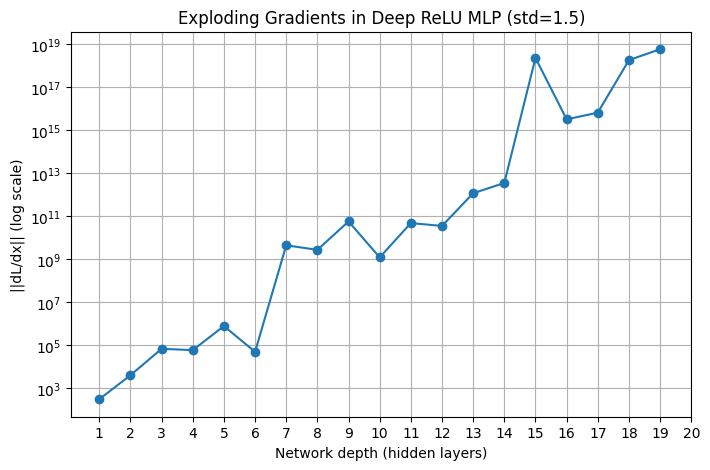

In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

torch.manual_seed(0)

class DeepMLP(nn.Module):
    def __init__(self, depth=5, width=128, weight_scale=1.5):
        super().__init__()
        layers = []
        for _ in range(depth):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())
        self.net = nn.Sequential(*layers)
        self.out = nn.Linear(width, 1)
        
        # Intentionally large weights → gradient explosion
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=weight_scale)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.out(self.net(x))

# Settings
depths = range(1, 21)
width = 10
weight_scale = 1.5
criterion = nn.MSELoss()

grad_norms = []

for D in depths:
    model = DeepMLP(depth=D, width=width, weight_scale=weight_scale)
    x = torch.randn(1, width, requires_grad=True)
    target = torch.randn(1, 1)
    
    output = model(x)
    loss = criterion(output, target)
    if x.grad is not None:
        x.grad.zero_()
    loss.backward()
    grad_norms.append(x.grad.norm().item())

# Plot gradient norms
plt.figure(figsize=(8, 5))
plt.semilogy(depths, grad_norms, 'o-')
plt.xlabel("Network depth (hidden layers)")
plt.ylabel("||dL/dx|| (log scale)")
plt.title(f"Exploding Gradients in Deep ReLU MLP (std={weight_scale})")
plt.grid(True, which="both")
plt.xticks(depths)
plt.show()


In [7]:
model

DeepMLP(
  (net): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=10, bias=True)
    (7): ReLU()
    (8): Linear(in_features=10, out_features=10, bias=True)
    (9): ReLU()
    (10): Linear(in_features=10, out_features=10, bias=True)
    (11): ReLU()
    (12): Linear(in_features=10, out_features=10, bias=True)
    (13): ReLU()
    (14): Linear(in_features=10, out_features=10, bias=True)
    (15): ReLU()
    (16): Linear(in_features=10, out_features=10, bias=True)
    (17): ReLU()
    (18): Linear(in_features=10, out_features=10, bias=True)
    (19): ReLU()
    (20): Linear(in_features=10, out_features=10, bias=True)
    (21): ReLU()
    (22): Linear(in_features=10, out_features=10, bias=True)
    (23): ReLU()
    (24): Linear(in_features=10, out_feature

# Exploding / Vanishing gradients and the importance of Kaiming(He-)-Weight initialization

He-Init std for ReLU (width=128): 0.1250
       Init  Depth     ||dL/dx||
0  std=0.01      1  1.595765e-02
1  std=0.01      2  6.977091e-04
2  std=0.01      3  4.853650e-05
3  std=0.01      4  2.500925e-06
4  std=0.01      5  6.106703e-08


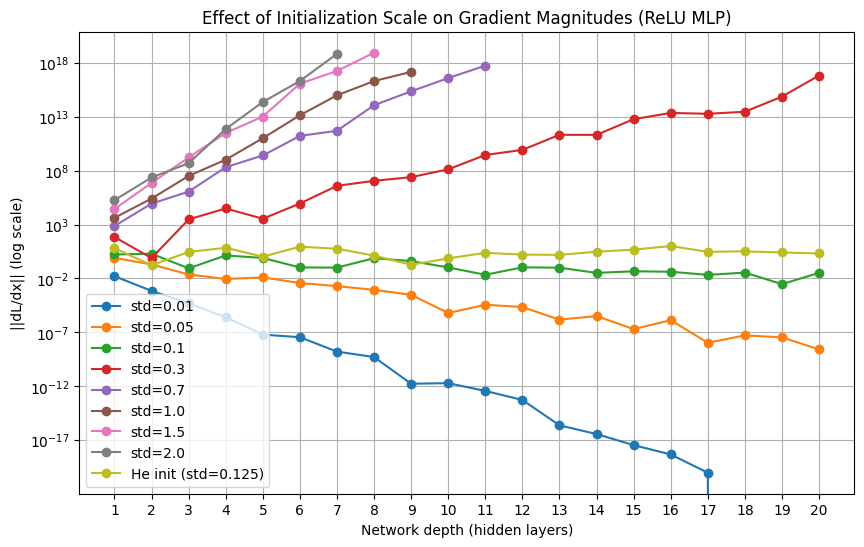

In [8]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

torch.manual_seed(0)

# ----- Model -----
class DeepMLP(nn.Module):
    def __init__(self, depth=12, width=128, init_std=1.0):
        super().__init__()
        layers = []
        for _ in range(depth):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU())            
        self.net = nn.Sequential(*layers)
        self.out = nn.Linear(width, 1)
        
        # Initialize all linear layers with specified std
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=init_std)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.out(self.net(x))

# ----- Helper function -----
def grad_norms_for_scale(depths, init_std, width=128):
    norms = []
    for D in depths:
        model = DeepMLP(depth=D, width=width, init_std=init_std)
        x = torch.randn(1, width, requires_grad=True)
        target = torch.randn(1, 1)
        y = model(x)
        loss = nn.MSELoss()(y, target)
        if x.grad is not None:
            x.grad.zero_()
        loss.backward()
        norms.append(x.grad.norm().item())
    return norms

# ----- Settings -----
depths = list(range(1, 21))
width = 128

# Compute He standard deviation for ReLU
he_std = (2.0 / width) ** 0.5
print(f"He-Init std for ReLU (width={width}): {he_std:.4f}")

# Scales to compare (include the He one)
scales = [0.01, 0.05, 0.1, 0.3, 0.7, 1.0, 1.5, 2.0, he_std]

# ----- Run experiments -----
results = {}
for s in scales:
    label = f"He init (std={s:.3f})" if abs(s - he_std) < 1e-6 else f"std={s}"
    results[label] = grad_norms_for_scale(depths, init_std=s, width=width)

# ----- Prepare DataFrame -----
rows = []
for label, norms in results.items():
    for d, n in zip(depths, norms):
        rows.append({"Init": label, "Depth": d, "||dL/dx||": n})
df = pd.DataFrame(rows)
print(df.head())

# ----- Plot -----
plt.figure(figsize=(10, 6))
for label, norms in results.items():
    plt.semilogy(depths, norms, marker='o', label=label)
plt.xlabel("Network depth (hidden layers)")
plt.ylabel("||dL/dx|| (log scale)")
plt.title("Effect of Initialization Scale on Gradient Magnitudes (ReLU MLP)")
plt.grid(True, which="both")
plt.legend()
plt.xticks(depths)
plt.show()
